Loading Kglobal_fine100.dat and Kglobal_fine140.dat...

--- Delta Analysis (t=0.10 vs t=0.06) ---
Total Added Stiffness (Delta Trace): -1.6799e+12
Top 3 Stiffening Modes (Delta Eigenvalues): [2.54169331e+10 2.86072294e+10 3.06923582e+10]


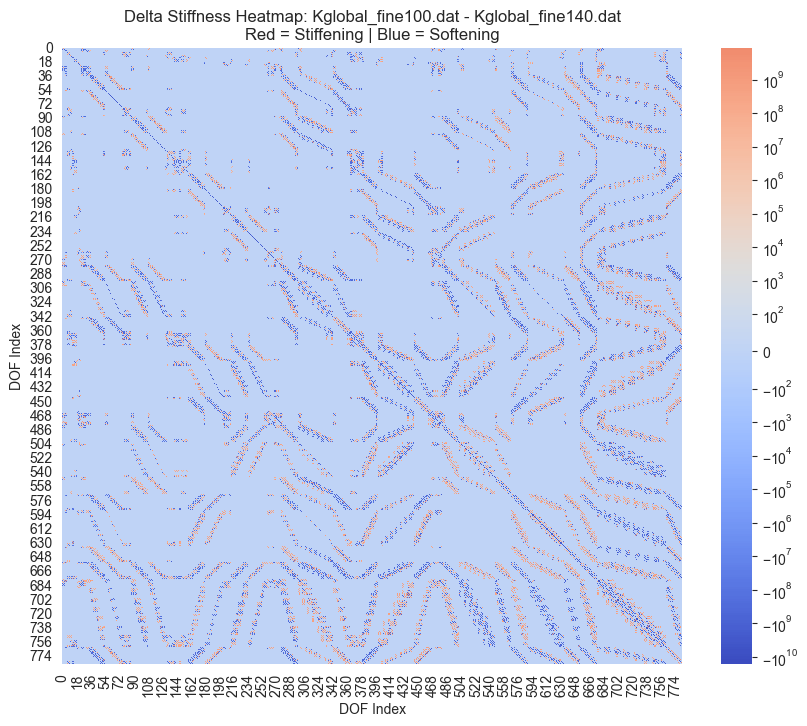

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm
from scipy.sparse import coo_matrix

# 1. SETUP AND DIRECTORY
os.chdir(r"C:\Calculix\ccx_2.23_wsl\Stiffness matrices")

def load_k_dense(filename):
    """Helper to load triplets and return a symmetric dense matrix."""
    data = np.loadtxt(filename)
    i = data[:, 0].astype(int) - 1
    j = data[:, 1].astype(int) - 1
    v = data[:, 2]

    ndof = int(max(i.max(), j.max()) + 1)
    K_ut = coo_matrix((v, (i, j)), shape=(ndof, ndof)).tocsr()
    # Symmetrize
    K_sparse = K_ut + K_ut.T - coo_matrix((K_ut.diagonal(), (range(ndof), range(ndof))), shape=(ndof, ndof)).tocsr()
    return K_sparse.toarray(), ndof

# 2. LOAD BOTH MATRICES
filename1 = "Kglobal_fine100.dat"
filename2 = "Kglobal_fine140.dat"

print(f"Loading {filename1} and {filename2}...")
K_dense_100, ndof1 = load_k_dense(filename1)
K_dense_060, ndof2 = load_k_dense(filename2)

if ndof1 != ndof2:
    raise ValueError(f"Matrix sizes do not match! {ndof1} vs {ndof2}. Ensure mesh is identical.")

# 3. CALCULATE THE DELTA MATRIX
Delta_K = K_dense_100 - K_dense_060

# 4. BASIC METRICS
delta_trace = np.trace(Delta_K)
print(f"\n--- Delta Analysis (t=0.10 vs t=0.06) ---")
print(f"Total Added Stiffness (Delta Trace): {delta_trace:.4e}")

# 5. EIGENVALUES OF THE CHANGE
# We use linalg.eigvalsh for dense symmetric matrices
delta_vals = np.linalg.eigvalsh(Delta_K)
# Focus on the most significant stiffening modes (the largest eigenvalues)
print(f"Top 3 Stiffening Modes (Delta Eigenvalues): {delta_vals[-3:]}")

# 6. VISUALIZATION (HEATMAP OF CHANGE)
plt.figure(figsize=(10, 8))
# SymLogNorm is great here because it handles the huge range and highlights the 'added' stiffness
sns.heatmap(Delta_K,
            norm=SymLogNorm(linthresh=1e2, vmin=Delta_K.min(), vmax=Delta_K.max()),
            cmap='coolwarm',
            center=0)

plt.title(f"Delta Stiffness Heatmap: {filename1} - {filename2}\nRed = Stiffening | Blue = Softening")
plt.xlabel("DOF Index")
plt.ylabel("DOF Index")
plt.show()